# NematicOrderParameter
The `freud.order` module provids the tools to calculate various [order parameters](https://en.wikipedia.org/wiki/Phase_transition#Order_parameters) that can be used to identify phase transitions.
This notebook demonstrates the [nematic order parameter](https://en.wikipedia.org/wiki/Liquid_crystal#Order_parameter), which can be used to identify systems with strong orientational ordering but no translational ordering.
For this example, we'll start with a set of random positions in a 3D system, each with a fixed, assigned orientation.
Then, we will show how deviations from these orientations are exhibited in the order parameter.

In [1]:
import freud
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import util

In order to work with orientations in freud, we need to do some math with quaternions.
If you are unfamiliar with quaternions, you can read more about [their definition](https://en.wikipedia.org/wiki/Quaternion) and how they can be used to [represent rotations](https://en.wikipedia.org/wiki/Quaternions_and_spatial_rotation).
For the purpose of this tutorial, just consider them as 4D vectors, and know that the set of normalized (*i.e.* unit norm) 4D vectors can be used to represent rotations in 3D.
In fact, there is a 1-1 mapping between normalize quaternions and 3x3 rotation matrices.
Quaternions are more computationally convenient, however, because they only require storing 4 numbers rather than 9, and they can be much more easily chained together.
For our purposes, you can largely ignore the contents of the next cell, other than to note that this is how we perform rotations of vectors using quaternions instead of matrices.

In [2]:
# These functions are adapted from the rowan quaternion library.
# See rowan.readthedocs.io for more information.
def quat_multiply(qi, qj):
    """Multiply two sets of quaternions."""
    output = np.empty(np.broadcast(qi, qj).shape)

    output[..., 0] = qi[..., 0] * qj[..., 0] - \
        np.sum(qi[..., 1:] * qj[..., 1:], axis=-1)
    output[..., 1:] = (qi[..., 0, np.newaxis] * qj[..., 1:] +
                       qj[..., 0, np.newaxis] * qi[..., 1:] +
                       np.cross(qi[..., 1:], qj[..., 1:]))
    return output

def quat_rotate(q, v):
    """Rotate a vector by a quaternion."""
    v = np.array([0, *v])
    
    q_conj = q.copy()
    q_conj[..., 1:] *= -1
    
    return quat_multiply(q, quat_multiply(v, q_conj))[..., 1:]

In [3]:
# Random positions are fine for this. Order is measured
# in terms of similarity of orientations, not positions.
L = 10
positions = np.random.rand(100, 3)*L - L/2
box = freud.box.Box.cube(L=L)
orientations = np.zeros((100, 4))
orientations[:, 0] = 1  # Quaternion (1, 0, 0, 0) is default orientation

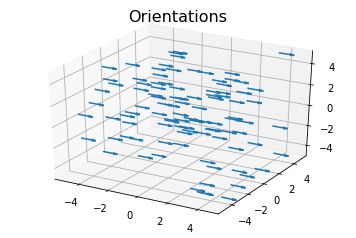

In [4]:
# To show orientations, we use arrows rotated by the quaternions.
arrowheads = quat_rotate(orientations, np.array([1, 0, 0]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver3D(positions[:, 0], positions[:, 1], positions[:, 2],
            arrowheads[:, 0], arrowheads[:, 1], arrowheads[:, 2])
ax.set_title("Orientations", fontsize=16);

The nematic order parameter provides a measure of how much of the system is aligned with respect to some provided reference vector.
As a result, we can now compute the order parameter for a few simple cases.
Since our original system is oriented along the x-axis, we can immediately test for that, as well as orientation along any of the other coordinate axes.

In [5]:
nop = freud.order.NematicOrderParameter([1, 0, 0])
nop.compute(orientations)
print("The value of the order parameter is {}.".format(nop.nematic_order_parameter))

The value of the order parameter is 1.0.


In general, the nematic order parameter is defined as the eigenvalue corresponding to the largest eigenvector of the nematic tensor, which is also computed by this class and provides an average over the orientations of all particles in the system.
As a result, we can also look at the intermediate results of our calculation and see how they are related.
To do so, let's consider a more interesting system with random orientations.

In [6]:
# Quaternions can be simply sampled as 4-vectors.
# Note that these samples are not uniformly distributed rotations,
# but that is not important for our current applications.
# However, we must ensure that the quaternions are normalized: 
# only unit quaternions represent rotations.
np.random.seed(0)
v = 0.05
orientations = np.random.multivariate_normal(mean=[1, 0, 0, 0], cov=v*np.eye(4), size=positions.shape[0])
orientations /= np.linalg.norm(orientations, axis=1)[:, np.newaxis]

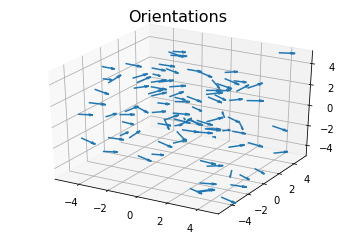

In [7]:
# To show orientations, we use arrows rotated by the quaternions.
arrowheads = quat_rotate(orientations, np.array([1, 0, 0]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver3D(positions[:, 0], positions[:, 1], positions[:, 2],
            arrowheads[:, 0], arrowheads[:, 1], arrowheads[:, 2])
ax.set_title("Orientations", fontsize=16);

First, we see that for this nontrivial system the order parameter now depends on the choice of director.

In [8]:
axes = [[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 1, 0], [1, 0, 1], [0, 1, 1], [1, 1, 1]]
for ax in axes:
    nop = freud.order.NematicOrderParameter(ax)
    nop.compute(orientations)
    print("For axis {}, the value of the order parameter is {:0.3f}.".format(ax, nop.nematic_order_parameter))

For axis [1, 0, 0], the value of the order parameter is 0.608.
For axis [0, 1, 0], the value of the order parameter is 0.564.
For axis [0, 0, 1], the value of the order parameter is 0.606.
For axis [1, 1, 0], the value of the order parameter is 0.611.
For axis [1, 0, 1], the value of the order parameter is 0.616.
For axis [0, 1, 1], the value of the order parameter is 0.577.
For axis [1, 1, 1], the value of the order parameter is 0.608.


Furthermore, increasing the amount of variance in the orientations depresses the value of the order parameter even further.

For axis [1, 0, 0], the value of the order parameter is 0.047.
For axis [0, 1, 0], the value of the order parameter is 0.075.
For axis [0, 0, 1], the value of the order parameter is 0.062.
For axis [1, 1, 0], the value of the order parameter is 0.090.
For axis [1, 0, 1], the value of the order parameter is 0.071.
For axis [0, 1, 1], the value of the order parameter is 0.069.
For axis [1, 1, 1], the value of the order parameter is 0.122.


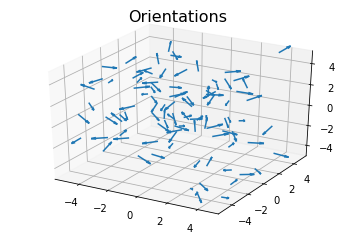

In [9]:
v = 0.5
orientations = np.random.multivariate_normal(mean=[1, 0, 0, 0], cov=v*np.eye(4), size=positions.shape[0])
orientations /= np.linalg.norm(orientations, axis=1)[:, np.newaxis]

arrowheads = quat_rotate(orientations, np.array([1, 0, 0]))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver3D(positions[:, 0], positions[:, 1], positions[:, 2],
            arrowheads[:, 0], arrowheads[:, 1], arrowheads[:, 2])
ax.set_title("Orientations", fontsize=16);

axes = [[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 1, 0], [1, 0, 1], [0, 1, 1], [1, 1, 1]]
for ax in axes:
    nop = freud.order.NematicOrderParameter(ax)
    nop.compute(orientations)
    print("For axis {}, the value of the order parameter is {:0.3f}.".format(ax, nop.nematic_order_parameter))


Finally, we can look at the per-particle quantities and build them up to get the actual value of the order parameter.

In [10]:
# The per-particle values averaged give the nematic tensor
print(np.allclose(np.mean(nop.particle_tensor, axis=0), nop.nematic_tensor))
print("The nematic tensor:")
print(nop.nematic_tensor)

eig = np.linalg.eig(nop.nematic_tensor)
print("The eigenvalues of the nematic tensor:")
print(eig[0])
print("The eigenvectors of the nematic tensor:")
print(eig[1])

# The largest eigenvalue
print("The largest eigenvalue, {:0.3f}, is equal to the order parameter {:0.3f}.".format(
    np.max(eig[0]), nop.nematic_order_parameter))

True
The nematic tensor:
[[-0.08164977 -0.00958257  0.05754685]
 [-0.00958257  0.02508486  0.07119219]
 [ 0.05754685  0.07119219  0.05656486]]
The eigenvalues of the nematic tensor:
[-0.11201978 -0.00962728  0.121647  ]
The eigenvectors of the nematic tensor:
[[-0.86846197 -0.45401222  0.19911498]
 [-0.27491584  0.7752717   0.5686608 ]
 [ 0.41254714 -0.43912038  0.7981091 ]]
The largest eigenvalue, 0.122, is equal to the order parameter 0.122.
